<a href="https://colab.research.google.com/github/RitikaHiremath/DataScience/blob/main/src/ipynb_notebooks/predictive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import numpy as np

def load_and_label_data(base_path, label, max_files=None):
    combined_100KHzdata = []
    combined_2000KHzdata = []

    file_counter = 0

    for timestamp_folder in os.listdir(base_path):
        if max_files and file_counter >= max_files:
            break

        timestamp_folder_path = os.path.join(base_path, timestamp_folder, "raw")
        timestamp = timestamp_folder.split('_')[0] + '_' + timestamp_folder.split('_')[1]
        timestamp = pd.to_datetime(timestamp, format='%Y.%m.%d_%H.%M.%S')

        # Process 2000KHz data
        df_2000KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling2000KHz_AEKi-0.parquet"))
        df_2000KHz_mean = df_2000KHz.mean().to_frame().T
        df_2000KHz_mean['timestamp'] = timestamp
        df_2000KHz_mean['label'] = label

        # Process 100KHz data
        df_100KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling100KHz_Irms_Grinding-Grinding spindle current L1-Grinding spindle current L2-Grinding spindle current L3-0.parquet"))
        df_100KHz_mean = df_100KHz.mean().to_frame().T
        df_100KHz_mean['timestamp'] = timestamp
        df_100KHz_mean['label'] = label

        combined_100KHzdata.append(df_100KHz_mean)
        combined_2000KHzdata.append(df_2000KHz_mean)

        file_counter += 1

    final_combined_100KHzdata = pd.concat(combined_100KHzdata, ignore_index=True)
    final_combined_2000KHzdata = pd.concat(combined_2000KHzdata, ignore_index=True)

    return final_combined_100KHzdata, final_combined_2000KHzdata

def preprocess_data(ok_data_path, nok_data_path):
    ok_100KHzdata, ok_2000KHzdata = load_and_label_data(ok_data_path, label=0)
    nok_100KHzdata, nok_2000KHzdata = load_and_label_data(nok_data_path, label=1)

    all_100KHzdata = pd.concat([ok_100KHzdata, nok_100KHzdata], ignore_index=True)
    all_2000KHzdata = pd.concat([ok_2000KHzdata, nok_2000KHzdata], ignore_index=True)

    combined_data = combine_and_interpolate_data(all_100KHzdata, all_2000KHzdata)
    normalized_data, scaler = normalize_data(combined_data)

    return normalized_data, scaler

def combine_and_interpolate_data(data_100KHz, data_2000KHz):
    combined_data = pd.merge_asof(
        data_100KHz.sort_values(by='timestamp'),
        data_2000KHz.sort_values(by='timestamp'),
        on='timestamp',
        by='label',
        direction='nearest'
    )

    combined_data = combined_data.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

    return combined_data

def normalize_data(combined_data, scaler=None):
    features = combined_data.drop(columns=['timestamp', 'label'])
    timestamps = combined_data['timestamp']
    labels = combined_data['label']

    if scaler is None:
        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(features)
    else:
        normalized_features = scaler.transform(features)

    normalized_data = pd.DataFrame(normalized_features, columns=features.columns)
    normalized_data.insert(0, 'timestamp', timestamps)
    normalized_data['label'] = labels.values

    return normalized_data, scaler

def create_labeled_sequences_for_future(data, sequence_length=10, prediction_length=1):
    sequences = []
    labels = []
    timestamps = []
    for i in range(len(data) - sequence_length - prediction_length + 1):
        seq = data.iloc[i:i+sequence_length, 1:-1].values
        label = data.iloc[i+sequence_length:i+sequence_length+prediction_length, -1].values
        timestamp = data.iloc[i+sequence_length:i+sequence_length+prediction_length, 0].values
        sequences.append(seq)
        labels.append(label)
        timestamps.append(timestamp)
    return np.array(sequences), np.array(labels), np.array(timestamps)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, RootMeanSquaredError
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd

def create_lstm_model_for_future(input_shape, output_units=1):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape, kernel_regularizer='l2'))
    model.add(Dropout(0.2))
    model.add(LSTM(50, kernel_regularizer='l2'))
    model.add(Dropout(0.2))
    model.add(Dense(output_units, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    return model

def train_model(model, X_train, y_train):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.3,
        callbacks=[early_stopping]
    )
    return history

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    evaluation_metrics = model.evaluate(X, y, verbose=0)
    loss = evaluation_metrics[0]
    accuracy = evaluation_metrics[1]
    precision = precision_score(y.flatten(), y_pred_classes.flatten())
    recall = recall_score(y.flatten(), y_pred_classes.flatten())
    f1 = f1_score(y.flatten(), y_pred_classes.flatten())
    auc_roc = roc_auc_score(y.flatten(), y_pred.flatten())

    return loss, accuracy, precision, recall, f1, auc_roc

def make_future_predictions(model, data, scaler, sequence_length=10, steps=5):
    future_predictions = []
    future_timestamps = []

    last_sequence = data.iloc[-sequence_length:, 1:-1].values
    current_timestamp = data.iloc[-1, 0]

    for step in range(steps):
        prediction = model.predict(last_sequence.reshape(1, sequence_length, -1))
        predicted_label = (prediction > 0.5).astype("int32")[0, 0]
        future_predictions.append(predicted_label)

        current_timestamp += pd.Timedelta(seconds=1)  # Adjust according to your timestamp resolution
        future_timestamps.append(current_timestamp)

        # Prepare the next sequence
        new_data_point = np.append(last_sequence[1:], [[predicted_label] * last_sequence.shape[1]], axis=0)
        last_sequence = new_data_point

    return future_timestamps, future_predictions

def evaluate_predictions(actual, predicted):
    precision = precision_score(actual, predicted, zero_division=1)
    recall = recall_score(actual, predicted, zero_division=1)
    f1 = f1_score(actual, predicted, zero_division=1)

    if len(set(actual)) > 1:  # Check if both classes are present
        auc_roc = roc_auc_score(actual, predicted)
    else:
        auc_roc = None

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    if auc_roc is not None:
        print(f"AUC-ROC: {auc_roc:.2f}")
    else:
        print("AUC-ROC: Not defined (only one class present in y_true)")

    return precision, recall, f1, auc_roc


In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_predictions(timestamps, actual, predicted):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(timestamps, actual, label='Actual', color='blue', marker='o', s=50)
    ax.scatter(timestamps, predicted, label='Predicted', color='red', marker='x', s=50)

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Anomaly')
    ax.set_title('Actual vs Predicted Anomalies')

    # Formatting the x-axis for better readability
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def print_and_plot_predictions(model, X, y, timestamps):
    y_pred = model.predict(X)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    # Flatten the arrays for printing
    y_true_flat = y.flatten()
    y_pred_flat = y_pred_classes.flatten()

    print("Timestamps:")
    print(timestamps)
    print("Actual Values:")
    print(y_true_flat)
    print("Predicted Values:")
    print(y_pred_flat)
    print("Evaluation Metrics for Predictions:")
    evaluate_predictions(y_true_flat, y_pred_flat)
    plot_predictions(timestamps.flatten(), y_true_flat, y_pred_flat)



Epoch 1/50


2/2 [==============================] - 4s 913ms/step - loss: 1.3970 - accuracy: 0.2174 - precision: 0.1429 - recall: 0.0769 - root_mean_squared_error: 0.5098 - val_loss: 1.3651 - val_accuracy: 0.1000 - val_precision: 0.2000 - val_recall: 0.1667 - val_root_mean_squared_error: 0.5064
Epoch 2/50
2/2 [==============================] - 0s 58ms/step - loss: 1.3618 - accuracy: 0.2609 - precision: 0.2500 - recall: 0.1538 - root_mean_squared_error: 0.5076 - val_loss: 1.3318 - val_accuracy: 0.1000 - val_precision: 0.2000 - val_recall: 0.1667 - val_root_mean_squared_error: 0.5060
Epoch 3/50
2/2 [==============================] - 0s 44ms/step - loss: 1.3263 - accuracy: 0.3913 - precision: 0.4545 - recall: 0.3846 - root_mean_squared_error: 0.5046 - val_loss: 1.2994 - val_accuracy: 0.1000 - val_precision: 0.2000 - val_recall: 0.1667 - val_root_mean_squared_error: 0.5057
Epoch 4/50
2/2 [==============================] - 0s 59ms/step - loss: 1.2946 - accuracy: 0.2609 - precision: 0.2500 - recall: 0.15

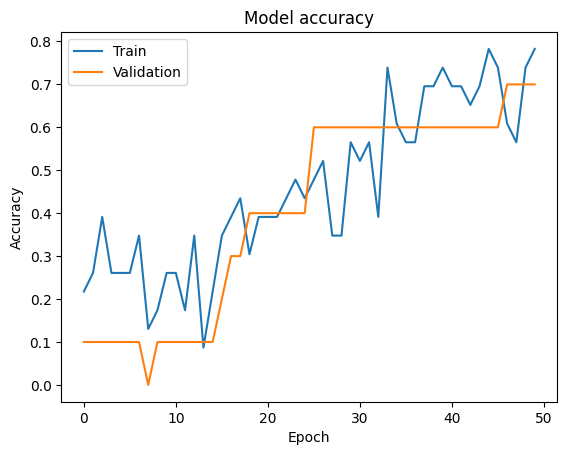

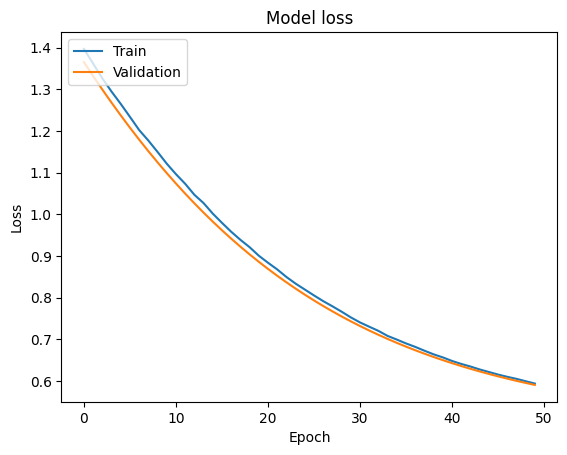

2/2 [==============================] - 1s 7ms/step
Training Loss: 0.5907, Training Accuracy: 78.79%, Training Precision: 1.00, Training Recall: 0.63, Training F1 Score: 0.77, Training AUC-ROC: 0.92
1/1 [==============================] - 0s 17ms/step
Test Loss: 0.5911, Test Accuracy: 66.67%, Test Precision: 1.00, Test Recall: 0.50, Test F1 Score: 0.67, Test AUC-ROC: 0.88
1/1 [==============================] - 0s 17ms/step
Timestamps:
[['2024-02-15T02:31:16.000000000']
 ['2024-02-15T02:37:22.000000000']
 ['2024-02-15T02:30:47.000000000']
 ['2024-02-15T02:38:43.000000000']
 ['2024-02-15T02:29:55.000000000']
 ['2024-02-15T02:35:59.000000000']
 ['2024-02-14T22:11:43.000000000']
 ['2024-02-15T02:27:22.000000000']
 ['2024-02-14T22:07:16.000000000']
 ['2024-02-15T02:30:21.000000000']
 ['2024-02-14T22:09:41.000000000']
 ['2024-02-14T22:06:46.000000000']
 ['2024-02-14T22:08:18.000000000']
 ['2024-02-15T02:36:54.000000000']
 ['2024-02-15T02:34:08.000000000']]
Actual Values:
[1 1 1 1 1 1 0 1 0 1 0

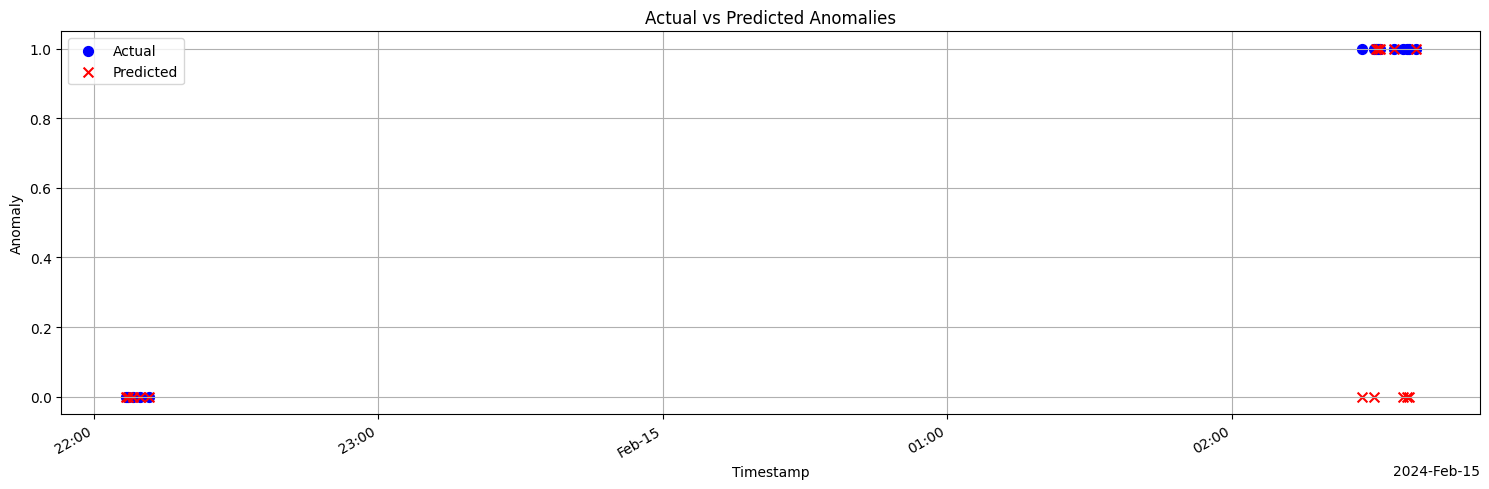

1/1 [==============================] - 0s 17ms/step
Future Timestamps Future Predictions
[Timestamp('2024-02-15 02:40:32'), Timestamp('2024-02-15 02:40:33'), Timestamp('2024-02-15 02:40:34'), Timestamp('2024-02-15 02:40:35'), Timestamp('2024-02-15 02:40:36')] [1, 1, 1, 1, 1]


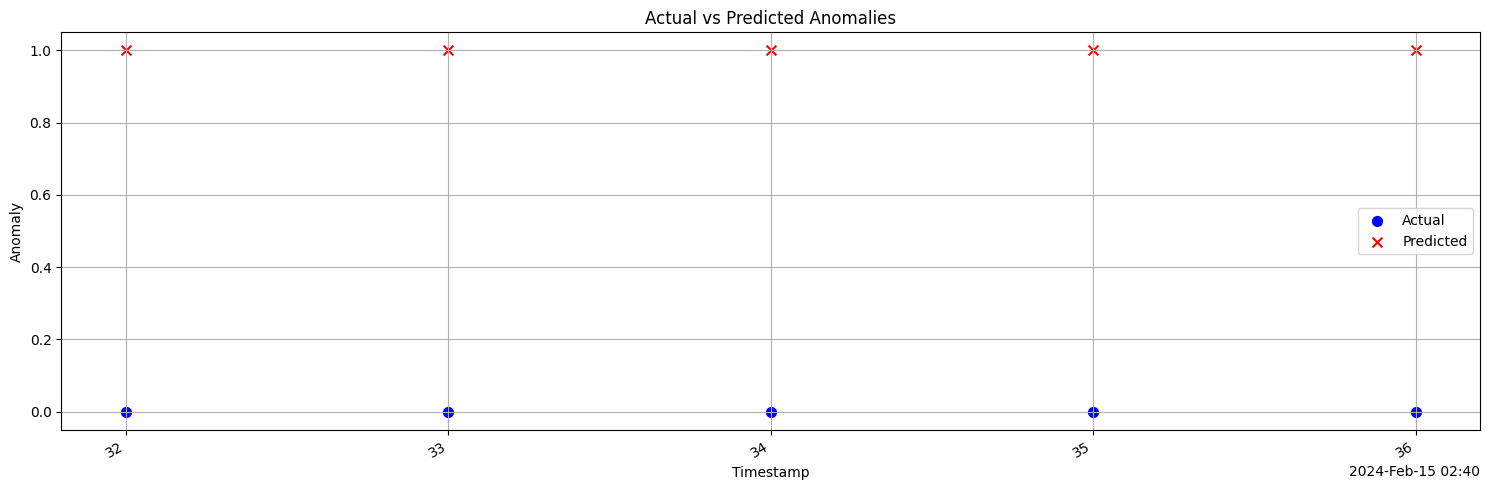


Results Summary:
    Dataset      Loss  Accuracy  Precision    Recall  F1 Score   AUC-ROC
0  Training  0.590728  0.787879        1.0  0.631579  0.774194  0.917293
1      Test  0.591144  0.666667        1.0  0.500000  0.666667  0.880000


In [21]:
import pandas as pd
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Define paths to data
ok_data_path = '/content/gdrive/MyDrive/Data/OK_Measurements'
nok_data_path = '/content/gdrive/MyDrive/Data/NOK_Measurements'

# Preprocess data
normalized_data, scaler = preprocess_data(ok_data_path, nok_data_path)

# Create labeled sequences for future prediction
sequence_length = 10
prediction_length = 1  # Predicting 1 step ahead
X_combined, y_combined, timestamps = create_labeled_sequences_for_future(normalized_data, sequence_length, prediction_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test, timestamps_train, timestamps_test = train_test_split(X_combined, y_combined, timestamps, test_size=0.3, random_state=42)

# Create LSTM model for future prediction
input_shape_combined = (sequence_length, X_combined.shape[2])
output_units = prediction_length
model_combined = create_lstm_model_for_future(input_shape_combined, output_units)

# Train the model
history = train_model(model_combined, X_train, y_train)

# Save the model
model_combined.save('AEGuard.keras')

# Plot results
plot_accuracy(history)
plot_loss(history)

# Evaluate the model on training data
train_loss, train_accuracy, train_precision, train_recall, train_f1, train_auc_roc = evaluate_model(model_combined, X_train, y_train)
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy*100:.2f}%, Training Precision: {train_precision:.2f}, Training Recall: {train_recall:.2f}, Training F1 Score: {train_f1:.2f}, Training AUC-ROC: {train_auc_roc:.2f}")

# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_auc_roc = evaluate_model(model_combined, X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%, Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1 Score: {test_f1:.2f}, Test AUC-ROC: {test_auc_roc:.2f}")

# Print and plot predictions for test data
print_and_plot_predictions(model_combined, X_test, y_test, timestamps_test)

# Make future predictions
future_steps = 5
future_timestamps, future_predictions = make_future_predictions(model_combined, normalized_data, scaler, sequence_length, future_steps)


print("Future Timestamps", "Future Predictions")
print(future_timestamps, future_predictions)


plot_predictions(future_timestamps, [0]*len(future_timestamps), future_predictions)

# Create a results table
results = {
    "Dataset": ["Training", "Test"],
    "Loss": [train_loss, test_loss],
    "Accuracy": [train_accuracy, test_accuracy],
    "Precision": [train_precision, test_precision],
    "Recall": [train_recall, test_recall],
    "F1 Score": [train_f1, test_f1],
    "AUC-ROC": [train_auc_roc, test_auc_roc]
}

results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)
